# Addressing Customer Churn in E-commerce: A Machine Learning–Based Predictive Approach
### Created By : Fahrezy Maulana Haz

## 1. Business Problem Understanding

**1.1 Background**

Perusahaan E-commerce menghadapi risiko kehilangan pelanggan (customer churn) yang berdampak langsung pada penurunan pendapatan serta meningkatnya biaya akuisisi pelanggan baru. Oleh karena itu, diperlukan pendekatan berbasis data untuk mengidentifikasi pelanggan yang berpotensi churn secara dini.

**1.2 Problem Statement**

Bagaimana membangun model Machine Learning yang mampu memprediksi pelanggan E-commerce yang berpotensi churn berdasarkan data historis pelanggan?

**1.3 Goals**

Memprediksi pelanggan yang berpotensi churn

Membantu perusahaan memfokuskan strategi retensi

Mengoptimalkan biaya promosi dan retensi

**1.4 Analytical Approach**

Supervised Learning – Classification

**1.5 Evaluation Metric**

F2-score dipilih sebagai metrik utama karena lebih menekankan recall (menghindari false negative churn).

## 2. Data Understanding

**2.1 Import Library**

In [95]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, fbeta_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, CondensedNearestNeighbour

import pickle


**2.2 Load Raw Data**

In [96]:
df_raw = pd.read_csv("data_ecommerce_customer_churn.csv")
df_raw.head()

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
3,20.0,25.0,4,Fashion,3,Divorced,7,0,NaN,230.27,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0


**2.3 Dataset Overview**

In [97]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3941 entries, 0 to 3940
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Tenure                    3747 non-null   float64
 1   WarehouseToHome           3772 non-null   float64
 2   NumberOfDeviceRegistered  3941 non-null   int64  
 3   PreferedOrderCat          3941 non-null   object 
 4   SatisfactionScore         3941 non-null   int64  
 5   MaritalStatus             3941 non-null   object 
 6   NumberOfAddress           3941 non-null   int64  
 7   Complain                  3941 non-null   int64  
 8   DaySinceLastOrder         3728 non-null   float64
 9   CashbackAmount            3941 non-null   float64
 10  Churn                     3941 non-null   int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 338.8+ KB


Target variable: **Churn**

## 3. Exploratory Data Analysis (EDA)

**3.1 Target Distribution**

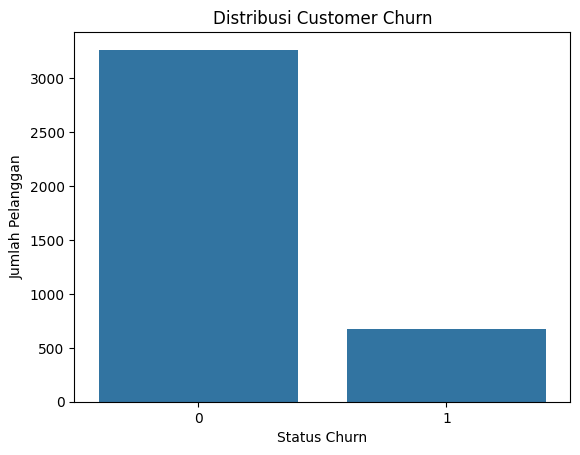

Churn
0    0.828977
1    0.171023
Name: proportion, dtype: float64

In [111]:
sns.countplot(x="Churn", data=df)
plt.title("Distribusi Customer Churn")
plt.xlabel("Status Churn")
plt.ylabel("Jumlah Pelanggan")
plt.show()

df["Churn"].value_counts(normalize=True)

Visualisasi distribusi target menunjukkan bahwa dataset customer churn bersifat tidak seimbang, dengan mayoritas pelanggan tidak churn. Oleh karena itu, diperlukan pendekatan pemodelan dan evaluasi yang mampu mendeteksi pelanggan churn secara lebih efektif dibandingkan sekadar mengandalkan akurasi.

**3.2 Numerical Features vs Churn**

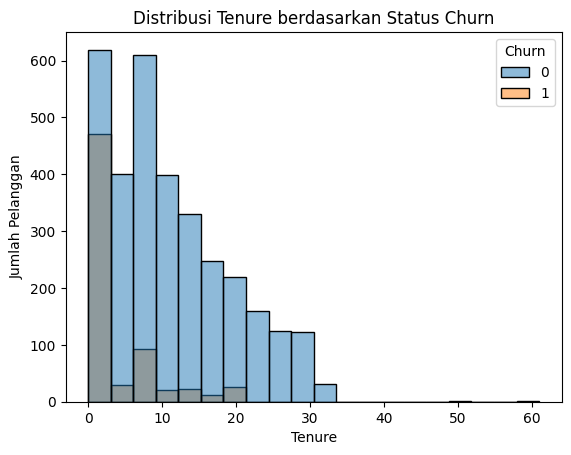

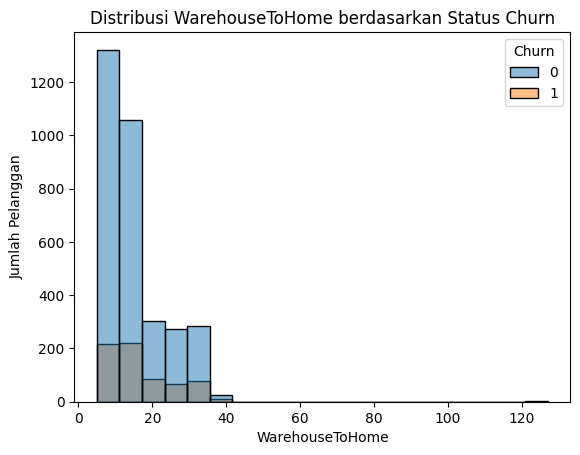

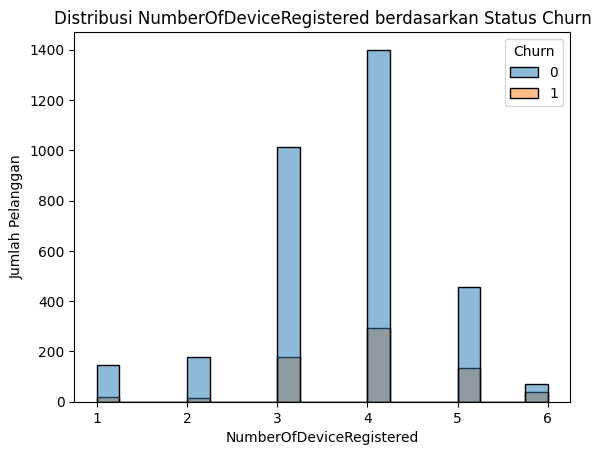

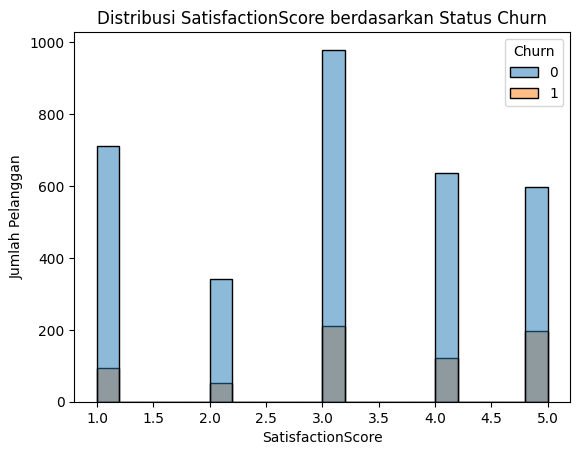

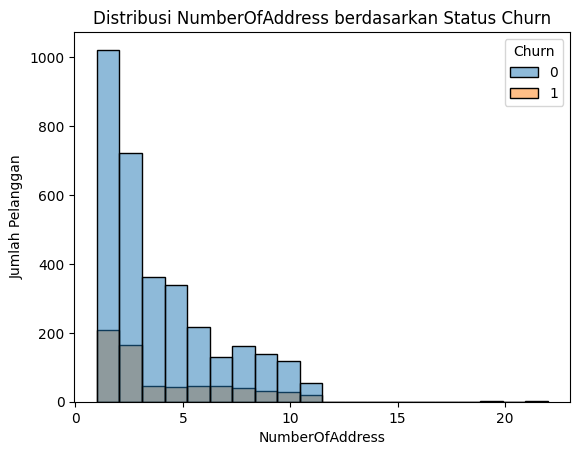

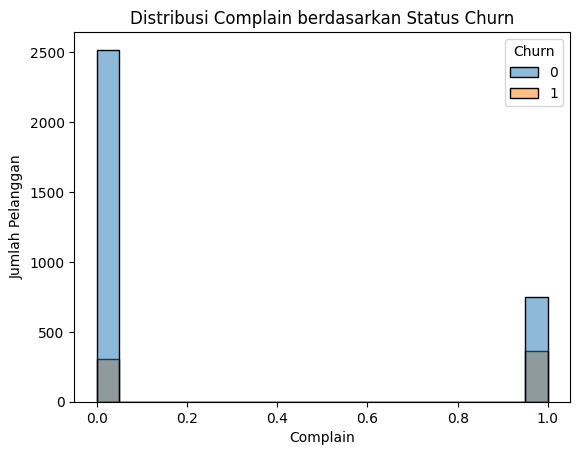

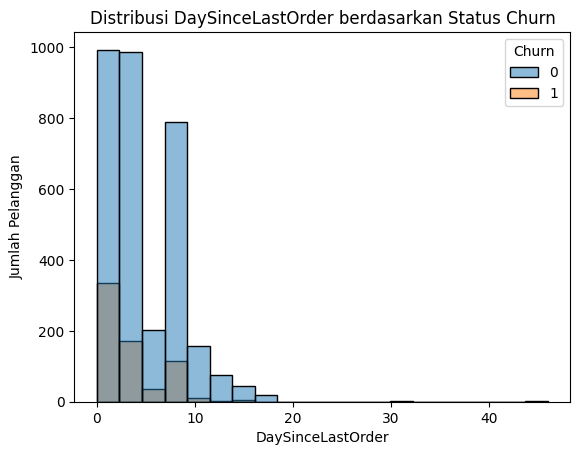

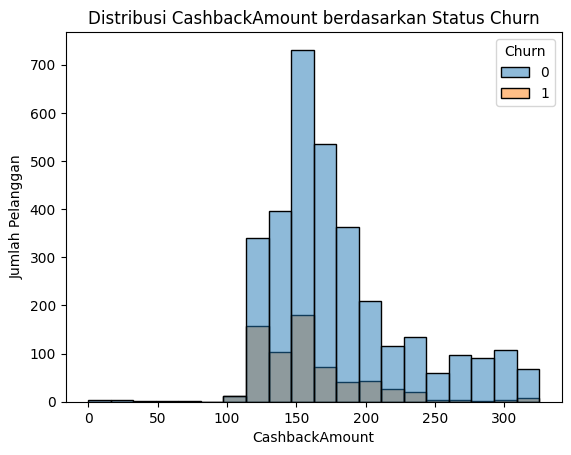

In [116]:
# Visualisasi distribusi fitur numerik berdasarkan status churn
for kolom in kolom_numerik:
    sns.histplot(data=df, x=kolom, hue="Churn", bins=20)
    plt.title(f"Distribusi {kolom} berdasarkan Status Churn")
    plt.xlabel(kolom)
    plt.ylabel("Jumlah Pelanggan")
    plt.show()

**Insight dari Histogram Fitur Numerik terhadap Churn**

**Tenure**
Pelanggan dengan masa berlangganan yang lebih pendek cenderung memiliki tingkat churn lebih tinggi. Pelanggan yang sudah lama bergabung relatif lebih loyal.

**DaySinceLastOrder**
Pelanggan yang sudah lama tidak melakukan transaksi terakhir lebih sering mengalami churn, menunjukkan penurunan engagement sebelum churn terjadi.

**CashbackAmount**
Pelanggan dengan cashback rendah lebih banyak ditemukan pada kelompok churn, mengindikasikan insentif finansial berpengaruh terhadap retensi.

**SatisfactionScore**
Skor kepuasan yang rendah lebih dominan pada pelanggan churn, menandakan kepuasan pelanggan merupakan faktor penting dalam mempertahankan pelanggan.

**NumberOfDeviceRegistered**
Pelanggan dengan jumlah perangkat yang terdaftar lebih sedikit cenderung lebih mudah churn dibandingkan pelanggan dengan banyak perangkat.

**OrderCount**
Frekuensi pemesanan yang rendah berkorelasi dengan churn yang lebih tinggi, menunjukkan pelanggan pasif lebih berisiko churn.

**WarehouseToHome**
Jarak pengiriman yang lebih jauh cenderung muncul pada pelanggan churn, kemungkinan terkait pengalaman pengiriman yang kurang optimal.

**HourSpendOnApp**
Waktu penggunaan aplikasi yang rendah lebih sering ditemukan pada pelanggan churn, mengindikasikan rendahnya engagement sebelum churn.

**3.3 Categorical Features vs Churn**

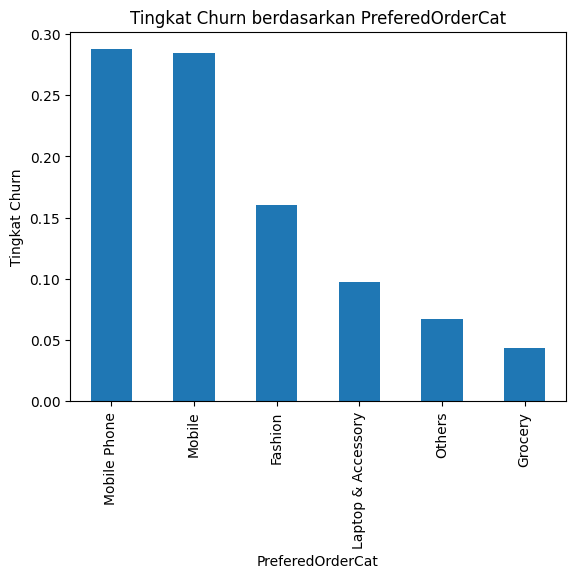

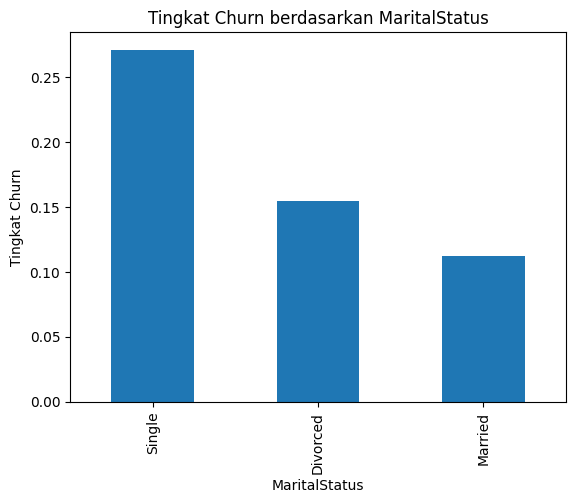

In [115]:
# Memilih seluruh kolom kategorikal
kolom_kategorikal = df.select_dtypes(include="object").columns

# Visualisasi churn rate untuk setiap fitur kategorikal
for kolom in kolom_kategorikal:
    tingkat_churn = df.groupby(kolom)["Churn"].mean().sort_values(ascending=False)
    tingkat_churn.plot(kind="bar")
    plt.title(f"Tingkat Churn berdasarkan {kolom}")
    plt.ylabel("Tingkat Churn")
    plt.xlabel(kolom)
    plt.show()


**Insight Tingkat Churn berdasarkan PreferredOrderCat**

- Pelanggan dengan kategori pesanan Mobile Phone dan Mobile memiliki tingkat churn paling tinggi.
- Kategori Grocery dan Others menunjukkan tingkat churn paling rendah, menandakan pelanggan pada  
  kategori ini lebih loyal.

- Hal ini mengindikasikan bahwa jenis produk yang sering dipesan berpengaruh terhadap risiko  
  churn, terutama pada produk bernilai tinggi dan bersifat non-rutin seperti gadget.

**Insight Tingkat Churn berdasarkan MaritalStatus**

- Pelanggan dengan status Single memiliki tingkat churn paling tinggi dibandingkan status lainnya.
- Pelanggan Married cenderung memiliki tingkat churn paling rendah.
- Ini menunjukkan bahwa stabilitas kondisi pribadi dapat berhubungan dengan loyalitas pelanggan 
  dalam menggunakan platform e-commerce.

## 4. Data Cleaning

In [101]:
df_clean = df.copy()

num_cols = df_clean.select_dtypes(include=["int64","float64"]).columns
cat_cols = df_clean.select_dtypes(include="object").columns

for col in num_cols:
    df_clean[col].fillna(df_clean[col].median(), inplace=True)

for col in cat_cols:
    df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)

df_clean.duplicated().sum()


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17264\3240224600.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[col].fillna(df_clean[col].median(), inplace=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_17264\3240224600.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


np.int64(672)

## 5. Feature Engineering

Dibuat dari **df_clean**

In [102]:
df_fe = df_clean.copy()

if "DaySinceLastOrder" in df_fe.columns:
    df_fe["RecencyFlag"] = (df_fe["DaySinceLastOrder"] > 30).astype(int)

if set(["Tenure","NumberOfDeviceRegistered"]).issubset(df_fe.columns):
    df_fe["EngagementScore"] = df_fe["Tenure"] * df_fe["NumberOfDeviceRegistered"]

if "CashbackAmount" in df_fe.columns:
    median_cb = df_fe["CashbackAmount"].median()
    df_fe["HighCashback"] = (df_fe["CashbackAmount"] > median_cb).astype(int)

if "Complaint" in df_fe.columns:
    df_fe["ComplaintFlag"] = (df_fe["Complaint"] == 1).astype(int)
    df_fe.drop(columns="Complaint", inplace=True)

df_fe.head()


,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn,RecencyFlag,EngagementScore,HighCashback
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0,0,60.0,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0,0,28.0,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0,0,81.0,1
3,20.0,25.0,4,Fashion,3,Divorced,7,0,3.0,230.27,0,0,80.0,1
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0,0,120.0,1


## 6. Train–Test Split

In [103]:
X = df_fe.drop("Churn", axis=1)
y = df_fe["Churn"]

x_train, x_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(x_train.shape)
print(y_train.shape)


(3152, 13)
(3152,)


## 7. Feature Preprocessing (Pipeline)

In [104]:
numeric_features = x_train.select_dtypes(include=["int64","float64"]).columns
categorical_features = x_train.select_dtypes(include="object").columns

numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
    ("encoder", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

transformer = ColumnTransformer([
    ("num", numeric_pipeline, numeric_features),
    ("cat", categorical_pipeline, categorical_features)
])

## 8. Baseline Model Benchmarking

In [117]:
list_classifier = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

f2_scorer = make_scorer(fbeta_score, beta=2)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model = ImbPipeline([
    ("preprocess", transformer),
    ("classifier", None)
])

results = []

for name, clf in list_classifier.items():
    model.set_params(classifier=clf)
    scores = cross_validate(
        model,
        x_train,
        y_train,
        scoring=f2_scorer,
        cv=cv,
        n_jobs=-1
    )
    results.append({
        "Model": name,
        "F2 Mean": scores["test_score"].mean()
    })

baseline_df = pd.DataFrame(results).sort_values("F2 Mean", ascending=False)
baseline_df

results = []

for name, clf in list_classifier.items():
    model.set_params(classifier=clf)
    
    scores = cross_validate(
        model,
        x_train,
        y_train,
        scoring=f2_scorer,
        cv=cv,
        n_jobs=-1,
        return_train_score=True
    )
    
    results.append({
        "Model": name,
        "Train F2 Mean": scores["train_score"].mean(),
        "Train F2 Std": scores["train_score"].std(),
        "Test F2 Mean": scores["test_score"].mean(),
        "Test F2 Std": scores["test_score"].std()
    })

baseline_df = pd.DataFrame(results).sort_values("Test F2 Mean", ascending=False)
baseline_df.reset_index(drop=True, inplace=True)

baseline_df



,Model,Train F2 Mean,Train F2 Std,Test F2 Mean,Test F2 Std
0,Random Forest,1.000000,0.000000,0.730256,0.040609
1,Decision Tree,1.000000,0.000000,0.705742,0.038844
2,Gradient Boosting,0.738164,0.008862,0.651771,0.032986
3,Logistic Regression,0.532017,0.013635,0.530986,0.041766
4,KNN,0.624623,0.012900,0.446364,0.048346


## 9. Resampling Strategy Selection

In [118]:
list_resampler = {
    "ROS": RandomOverSampler(random_state=42),
    "SMOTE": SMOTE(random_state=42),
    "RUS": RandomUnderSampler(random_state=42),
    "CNN": CondensedNearestNeighbour(random_state=42)
}

model_resampling = ImbPipeline([
    ("preprocess", transformer),
    ("resampling", None),
    ("classifier", RandomForestClassifier(random_state=42, n_jobs=-1))
])

grid_resampling = GridSearchCV(
    model_resampling,
    {"resampling": list(list_resampler.values())},
    scoring=f2_scorer,
    cv=cv,
    n_jobs=-1
)

grid_resampling.fit(x_train, y_train)

best_resampler = grid_resampling.best_params_["resampling"]
best_resampler


,sampling_strategy,'auto'
,random_state,42
,n_neighbors,None
,n_seeds_S,1
,n_jobs,None


## 10. Hyperparameter Tuning

In [119]:
final_pipeline = ImbPipeline([
    ("preprocess", transformer),
    ("resampling", best_resampler),
    ("classifier", RandomForestClassifier(random_state=42, n_jobs=-1))
])

param_grid = {
    "classifier__n_estimators": [200, 300],
    "classifier__max_depth": [None, 10, 20],
    "classifier__min_samples_split": [2, 5],
    "classifier__min_samples_leaf": [1, 2],
    "classifier__max_features": ["sqrt", "log2"]
}

grid_model = GridSearchCV(
    final_pipeline,
    param_grid,
    scoring=f2_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

grid_model.fit(x_train, y_train)

best_model = grid_model.best_estimator_
grid_model.best_params_


Fitting 5 folds for each of 48 candidates, totalling 240 fits


{'classifier__max_depth': 20,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 2,
 'classifier__n_estimators': 300}

## 11. Final Evaluation (Test Set)

              precision    recall  f1-score   support

           0       0.96      0.91      0.94       654
           1       0.66      0.83      0.74       135

    accuracy                           0.90       789
   macro avg       0.81      0.87      0.84       789
weighted avg       0.91      0.90      0.90       789



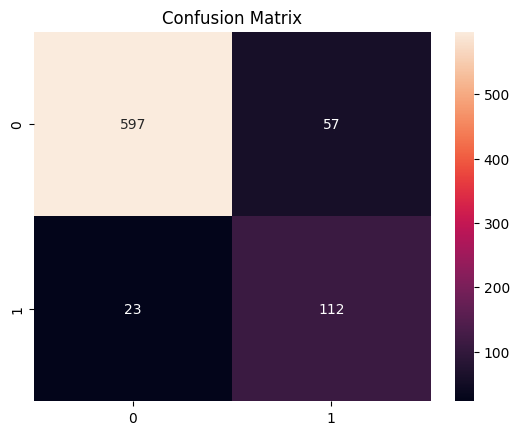

In [120]:
y_pred = best_model.predict(x_test)

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.show()


**Insight Evaluasi Model**

- Model mampu mengidentifikasi pelanggan churn dengan baik, ditunjukkan oleh recall kelas churn 
  (1) sebesar 83%, artinya sebagian besar pelanggan yang benar-benar churn berhasil terdeteksi.

- Terdapat 23 pelanggan churn yang tidak terdeteksi (false negative), yang berpotensi menyebabkan 
  kehilangan pelanggan jika tidak ditangani.

- Precision churn sebesar 66% menunjukkan masih ada pelanggan yang diprediksi churn tetapi 
  sebenarnya tidak churn, namun hal ini dapat diterima karena tujuan utama adalah meminimalkan kehilangan pelanggan.

- Akurasi model mencapai 90%, namun metrik yang lebih relevan adalah recall churn karena churn 
  merupakan kelas minoritas dengan dampak bisnis lebih besar.

## 12. Save Model

In [121]:
with open("churn_model.pkl", "wb") as file:
    pickle.dump(best_model, file)


## 13. Conclusion & Recommendation

**Conclusion**

Model Random Forest dengan resampling dan hyperparameter tuning menunjukkan performa terbaik dalam mendeteksi customer churn berdasarkan F2-score.

**Recommendation**

Fokuskan retention campaign pada pelanggan dengan probabilitas churn tinggi

Gunakan model sebagai early warning system

F2 digunakan karena dalam kasus customer churn, kesalahan paling mahal adalah gagal mendeteksi pelanggan yang akan churn (false negative), sehingga recall harus diprioritaskan dibanding precision.